# Visualization of b5

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot, plot_confusion_matrix
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

### Preparing data

In [3]:
df2 = pd.read_csv("data/boolean5_train.csv")
df2_test = pd.read_csv("data/boolean5_test.csv")

df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [4]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Roland created a shy and wonderful work of art,Roland didn't create a delightful work of art,Roland created a shy work of art,Roland created a wonderful work of art,0,Roland created a shy and wonderful work of art...
8496,Tracy created a powerful and stocky work of art,Samantha didn't create a powerful work of art,Tracy created a powerful work of art,Tracy created a stocky work of art,0,Tracy created a powerful and stocky work of ar...
8497,Joann created a repulsive and flabby work of art,Joann didn't create a polite work of art,Joann created a repulsive work of art,Joann created a flabby work of art,0,Joann created a repulsive and flabby work of a...
8498,Joshua created a jolly and black work of art,Joshua didn't create a jolly work of art,Joshua created a jolly work of art,Joshua created a black work of art,1,Joshua created a jolly and black work of art J...
8499,Alison created an ashy and helpful work of art,Alison didn't create a pitiful work of art,Alison created an ashy work of art,Alison created a helpful work of art,0,Alison created an ashy and helpful work of art...


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [7]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [8]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [9]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
f = lambda x: len(x.split(" "))

MAX_LENGTH = np.max(list(map(f, all_sentences)))

In [11]:
MAX_LENGTH = 20

def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [12]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [13]:
_, _, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 773
eng_dec 772

Read 11000 sentence pairs
Trimmed to 11000 sentence pairs
Counting words...
Counted words:
eng_enc 776
eng_dec 776


Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 701
eng_dec 700


In [14]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 773
eng_dec 772

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 701
eng_dec 700


### sentences 2 tensors

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [16]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
def tensorsFromTriple(triple):
    input_tensor = tensorFromSentence(input_lang, triple[0])
    target_tensor = tensorFromSentence(output_lang, triple[1])
    label_tensor = torch.tensor(triple[2], dtype=torch.long).view((1))
    return (input_tensor, target_tensor, label_tensor)

### models

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
hidden_size = 256
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [22]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))

In [23]:
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

## translating

In [24]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a trained model: and A

In [25]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderA,
                                   decoderA,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : jeffery created a silly and vast work of art
neural translation : brenda created a blue work of art <EOS>
reference translation : jeffery created a silly work of art <EOS>
blue score = 0.41

input_sentence : hilda created a zealous and better work of art
neural translation : brenda created a white work of art <EOS>
reference translation : hilda created a zealous work of art <EOS>
blue score = 0.41

input_sentence : cheryl created an ugly and obedient work of art
neural translation : brenda created an ugly work of art <EOS>
reference translation : cheryl created an ugly work of art <EOS>
blue score = 0.84



## translation of a trained model: and B

In [26]:
for t in training_pairs_B[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderB,
                                   decoderB,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : jeffery created a silly and vast work of art
neural translation : marion created a vast work of art <EOS>
reference translation : jeffery created a vast work of art <EOS>
blue score = 0.84

input_sentence : hilda created a zealous and better work of art
neural translation : marion created a better work of art <EOS>
reference translation : hilda created a better work of art <EOS>
blue score = 0.84

input_sentence : cheryl created an ugly and obedient work of art
neural translation : jessie created an obedient work of art <EOS>
reference translation : cheryl created an obedient work of art <EOS>
blue score = 0.84



In [27]:
valid_triples = zip(list(df2valid.sentence1.values), list(df2valid.sentence2.values), list(df2valid.label.values))
valid_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in valid_triples]
valid_triples_t = [tensorsFromTriple(t) for t in valid_triples]

# Models

In [28]:
class AndModelZero(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelZero, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        outs = []
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            outs.append(encoder_output)
                    
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = None
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [29]:
class AndModelA(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelA, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        outs = []
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            outs.append(encoder_output)
                    
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = hA
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [30]:
class AndModelB(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelB, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        outs = []
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            outs.append(encoder_output)
                    
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = hB
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices


In [31]:
class AndModelDot(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelDot, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        outs = []
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            outs.append(encoder_output)
                    
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = hA * hB
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

## EXAMPLE

In [32]:
addmodel = AndModelA(encoderA,
                     decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=256,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

In [33]:
for ex in training_pairs_B[0:3]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    
    ex_A = addmodel.sen2vec(ex,
                     addmodel.encoderA,
                     addmodel.decoderA,
                     is_tensor=False,
                     out_tensor=False)
    
    ex_B = addmodel.sen2vec(ex,
                     addmodel.encoderB,
                     addmodel.decoderB,
                     is_tensor=False,
                     out_tensor=False)

    print("inference A:\n")
    print(ex_A)
    print()
    print("inference B:\n")
    print(ex_B)

s1:

jeffery created a silly and vast work of art

inference A:

brenda created a blue work of art <EOS>

inference B:

marion created a vast work of art <EOS>
s1:

hilda created a zealous and better work of art

inference A:

brenda created a vast work of art <EOS>

inference B:

marion created a better work of art <EOS>
s1:

cheryl created an ugly and obedient work of art

inference A:

brenda created an ugly work of art <EOS>

inference B:

jessie created an obedient work of art <EOS>


Visualization

In [34]:
def sentence_plot(sentences, values, title=None):
    """
    plot the values of one dimension of the hidden vector to
    each word in the sentence.

    :param sentences: sentences to be printed
    :type sentences: list of str 
    :param values: one dimension of the hidden vector 
                   for each word of the sentence
    :type values: np.array(shape=(num_sentences, sent_len))
    """
    assert len(sentences) == values.shape[0]
    for sentence in sentences:
        assert len(sentence.split()) == values.shape[1]

    all_values = []
    sentence_size = np.max([len(sentence) for sentence in sentences])
    for sid, sentence in enumerate(sentences):
        temp = np.zeros((sentence_size))
        count = 0
        for wid, word in enumerate(sentence.split()):
            temp[count: count + len(word)] = values[sid][wid]
            count = count + len(word) + 1
        all_values.append(temp)
    all_values = np.array(all_values)

    height = all_values.shape[0] 
    width = all_values.shape[1]
    
    plt.figure(figsize=(width * 1.6, height * 0.3))
    plt.title(title)
    plt.imshow(all_values, interpolation='none',
             cmap='Oranges')
    plt.axis('off')
    for sid, sentence in enumerate(sentences):
        for wid, word in enumerate(sentence):
            plt.text(wid-0.2,sid+0.2,word,color='k',fontsize=12)

    plt.show()
    plt.close()

In [35]:
sent_and_triples = list(zip(valid_triples, valid_triples_t))

Using only one example

Applying a function to a fixed set of sentences 

In [36]:
valid_examples = [sent_and_triples[i] for i in [1, 0, 1120, 1118, 1379, 788, 313, 350, 755, 1062]]

valid_examples_sen = [i[0][1] for i in valid_examples]
valid_examples_s1_s2 = [(i[1][0], i[1][1]) for i in valid_examples]

In [37]:
from sklearn.decomposition import PCA
projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}

projector = projector_fun(n_components=3, **kwargs[projector])

In [38]:
def transform_to_plot(valid_examples_sen, valid_examples_s1_s2, model):

    max_size = np.max([len(sentence.split()) for sentence in valid_examples_sen])
    encodings = []

    for tuple_ in valid_examples_s1_s2:
        s1, s2 = tuple_
        model(s1, s2)
        encodings.append(model.output[:-1].detach().numpy())

    new = []

    for array in encodings:
        new.append(projector.fit_transform(array))    

    new_p = []

    for array in new:
        size = array.shape[0]
        if size < max_size:
            diff = max_size - size
            zero = np.zeros((diff, array.shape[1]))
            array_p = np.concatenate([array, zero])
            new_p.append(array_p)
        else:
            new_p.append(array)

    valid_examples_sen_p = []

    for sen in valid_examples_sen:
        size = len(sen.split(" "))
        if size < max_size:
            diff = max_size - size
            pads = [" <pad>"] * diff
            for i in pads:
                sen += i 
            valid_examples_sen_p.append(sen)
        else:
            valid_examples_sen_p.append(sen)
            

    valid_encodings = np.stack(new_p)
    
    return valid_examples_sen_p, valid_encodings

In [39]:
valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen, valid_examples_s1_s2, addmodel)

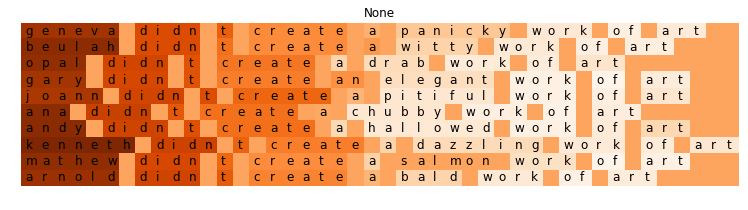

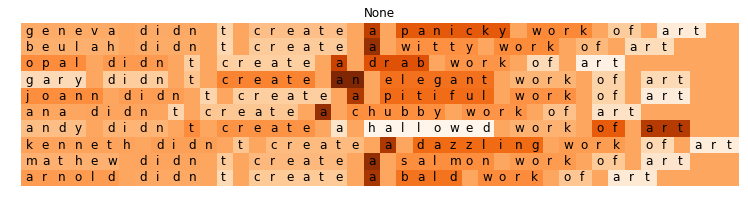

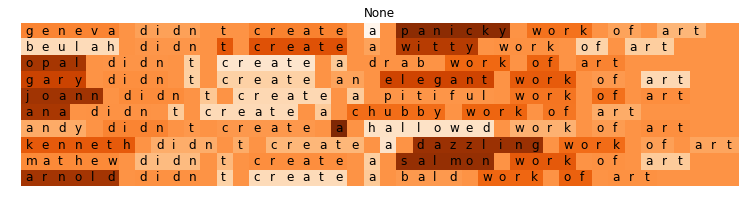

In [40]:
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

### Showing results

Fixing results

In [41]:
valid_examples = [sent_and_triples[i] for i in [1, 0, 1120, 1118, 1379, 788, 313, 350, 755, 1062]]

valid_examples_sen = [i[0][1] for i in valid_examples]

valid_examples_sen1 = [i[0][0] for i in valid_examples]

valid_examples_s1_s2 = [(i[1][0], i[1][1]) for i in valid_examples]

In [42]:
for i, e in zip(valid_examples_sen1, valid_examples_sen):
    print(i)
    print(e)
    print()

priscilla created a panicky and mysterious work of art
geneva didn t create a panicky work of art

beulah created a skinny and zealous work of art
beulah didn t create a witty work of art

laura created an ugly and drab work of art
opal didn t create a drab work of art

samuel created an elegant and delightful work of art
gary didn t create an elegant work of art

joann created a pitiful and scruffy work of art
joann didn t create a pitiful work of art

ana created a chubby and uninterested work of art
ana didn t create a chubby work of art

andy created a hallowed and drab work of art
andy didn t create a hallowed work of art

kenneth created a dazzling and bald work of art
kenneth didn t create a dazzling work of art

john created a salmon and embarrassed work of art
mathew didn t create a salmon work of art

ashley created an unimportant and bald work of art
arnold didn t create a bald work of art



# Showing visualization on diferrent models

## ZERO

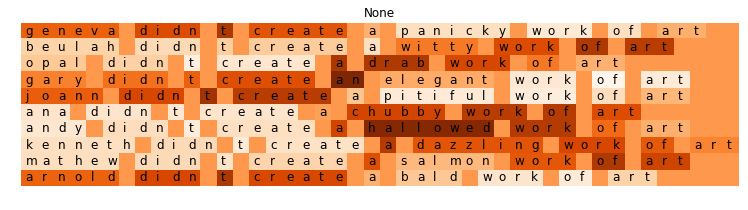

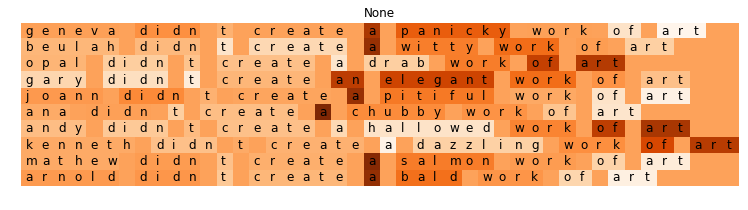

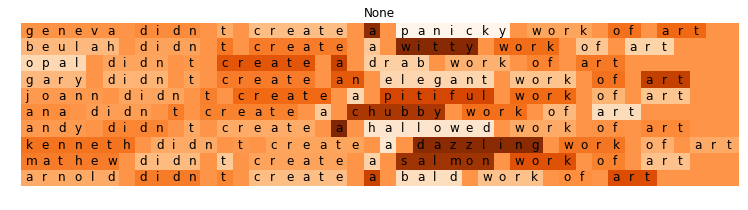

In [43]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

addmodelzero = AndModelZero(encoderA,
                      decoderA,
                      encoderB,
                      decoderB,
                      hidden_size=256,
                      output_size=2,
                      max_length=MAX_LENGTH,
                      input_lang=input_lang,
                      target_lang=output_lang)

# addmodelA.load_state_dict(torch.load("b3_simpleA.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodelzero)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

## projection of the first argument

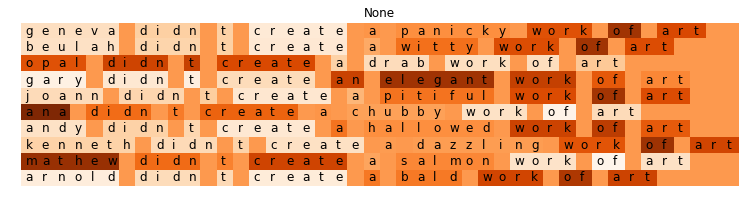

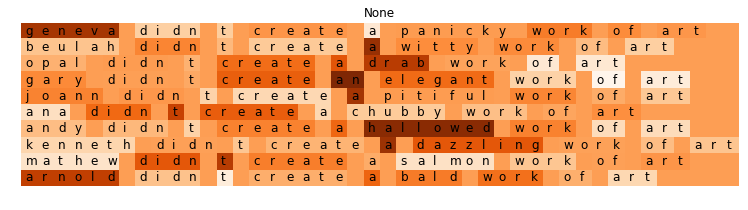

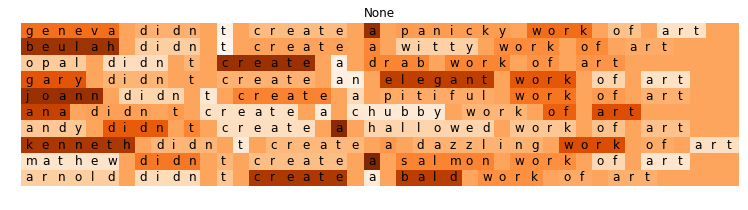

In [44]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

addmodelA = AndModelA(encoderA,
                      decoderA,
                      encoderB,
                      decoderB,
                      hidden_size=256,
                      output_size=2,
                      max_length=MAX_LENGTH,
                      input_lang=input_lang,
                      target_lang=output_lang)

addmodelA.load_state_dict(torch.load("b5_simpleA.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodelA)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

## Project second argument

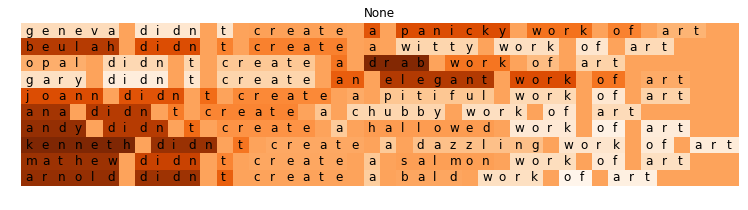

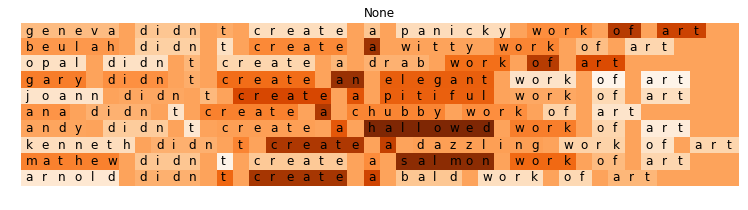

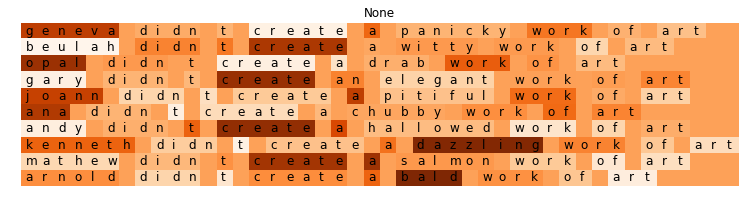

In [45]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

addmodelb = AndModelB(encoderA,
                      decoderA,
                      encoderB,
                      decoderB,
                      hidden_size=256,
                      output_size=2,
                      max_length=MAX_LENGTH,
                      input_lang=input_lang,
                      target_lang=output_lang)

addmodelb.load_state_dict(torch.load("b5_simpleB.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodelb)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

## Combining the both projections

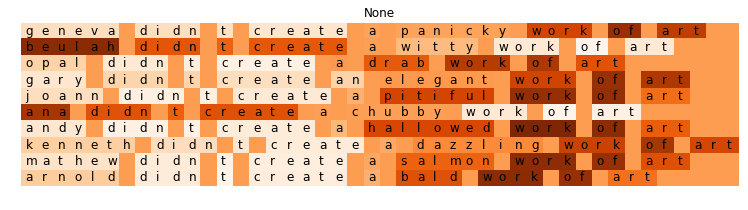

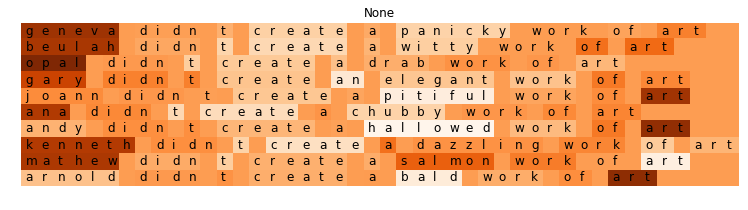

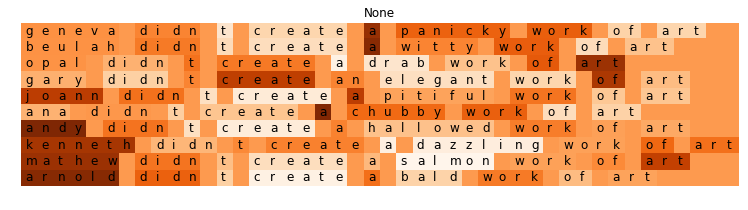

In [46]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

addmodeldot = AndModelDot(encoderA,
                      decoderA,
                      encoderB,
                      decoderB,
                      hidden_size=256,
                      output_size=2,
                      max_length=MAX_LENGTH,
                      input_lang=input_lang,
                      target_lang=output_lang)

addmodeldot.load_state_dict(torch.load("b5_dot.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodeldot)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])